# Use Case: Samples without prior pathogen isolation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy
import seaborn as sns
import upsetplot as upset

from clustergrammer2 import Network, CGM2
from pathlib import Path

data_dp = Path("../data/samples_without_prior_pathogen_isolation/")
output_dp = Path("../results/samples_without_prior_pathogen_isolation/")

>> clustergrammer2 backend version 0.18.0


# Reading Galaxy_Input tabulars to dataframes

In [ ]:
vfs_amrs_counts_db = pd.read_table(data_dp / Path("vfs_amrs_count_table.tsv"))
vfs_amrs_counts_db.set_index("key", inplace=True)
metadata_db = pd.read_table(data_dp / Path("metadata.tsv"))
metadata_db.set_index("Galaxy ID", inplace=True)
metadata_db.index.name = "key"
hosts_db = pd.read_table(data_dp / Path("removed_hosts_percentage_tabular.tsv"))
hosts_db.set_index("key", inplace=True)
heatmap_db = pd.read_table(data_dp / Path("heatmap_tabular.tsv"))
heatmap_db.set_index("key", inplace=True)
snps_count_db = pd.read_table(data_dp / Path("number_of_snps_or_variants_found_per_sample.tsv"))
snps_count_db.set_index("key", inplace=True)
mapping_coverage_db = pd.read_table(data_dp / Path("mapping_to_salmonella_rg_coverage_percentage_per_sample.tsv"))
mapping_coverage_db.set_index("key", inplace=True)
coverage_heatmap_db = pd.read_table(data_dp / Path("vfs_coverage_heatmap.tsv"))
coverage_heatmap_db.set_index("key", inplace=True)
samples_depth_mean_db = pd.read_table(data_dp / Path("samplesdepthmean.tsv"))
samples_depth_mean_db.set_index("key", inplace=True)
heatmap_benchmark_db= pd.read_table(data_dp / Path("benchmark_results_heatmap_table.tsv"))
heatmap_benchmark_db.set_index("ExpectedPathogen", inplace=True)

# Mapping VFs and AMRs count to the Metadata Tabular

In [3]:
frames = [vfs_amrs_counts_db, hosts_db ,metadata_db,snps_count_db,mapping_coverage_db,samples_depth_mean_db]
result = pd.concat(frames, axis = 1)
result = result.sort_values(['Adaptive sampling during sequencing (Chicken Excluded)','Incubation before DNA isolation','Expected strain(s)'])

result.to_csv(output_dp / Path("metadatacombined.csv"), index=False)
print(result)

                  VFs count  AMRs count  quality_retained_all_reads  \
key                                                                   
Spike4Barcode15         8.0         0.0                      134030   
Spike4Barcode14         0.0         0.0                       71997   
Spike4Barcode13         0.0         0.0                      106376   
Spike4Barcode16         1.0         0.0                      127337   
Spike1Barcode13         0.0         0.0                       69378   
Spike2Barcode13         0.0         0.0                       83232   
Spike2bBarcode13        0.0         0.0                      102959   
Spike3bBarcode13        0.0         0.0                       25197   
Spike4Barcode01        78.0         3.0                       87543   
Spike4Barcode04         0.0         0.0                      155057   
Spike4Barcode02         NaN         NaN                       65680   
Spike4Barcode03         NaN         NaN                       29301   
Spike1

# Plots

## Bar Plot VFs/AMRs count vs. Enrichment

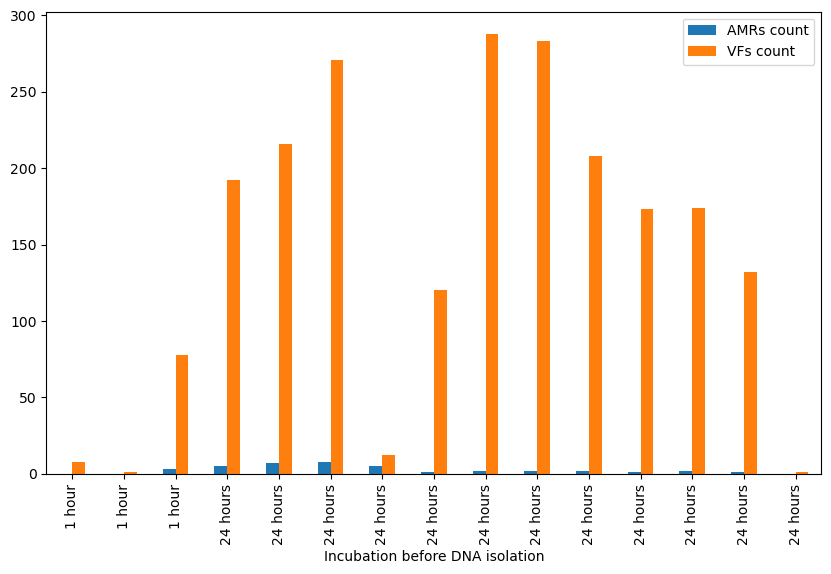

In [4]:
selection = result[(result["AMRs count"] != 0) | (result["VFs count"] != 0)]
selection = selection.dropna(subset = ["AMRs count","VFs count"])

selection.set_index(["Incubation before DNA isolation"], drop=True, inplace = True)
selection.plot( kind = "bar",
                y = ["AMRs count","VFs count"], 
                figsize=(10,6), 
                )
plt.savefig(output_dp / Path("bar_plot_vfs_amrs_counts_vs_incubation.svg"))
plt.savefig(output_dp / Path("bar_plot_vfs_amrs_counts_vs_incubation.png"))
plt.show()

## Percentages of removed QC hosts reads vs Sample information

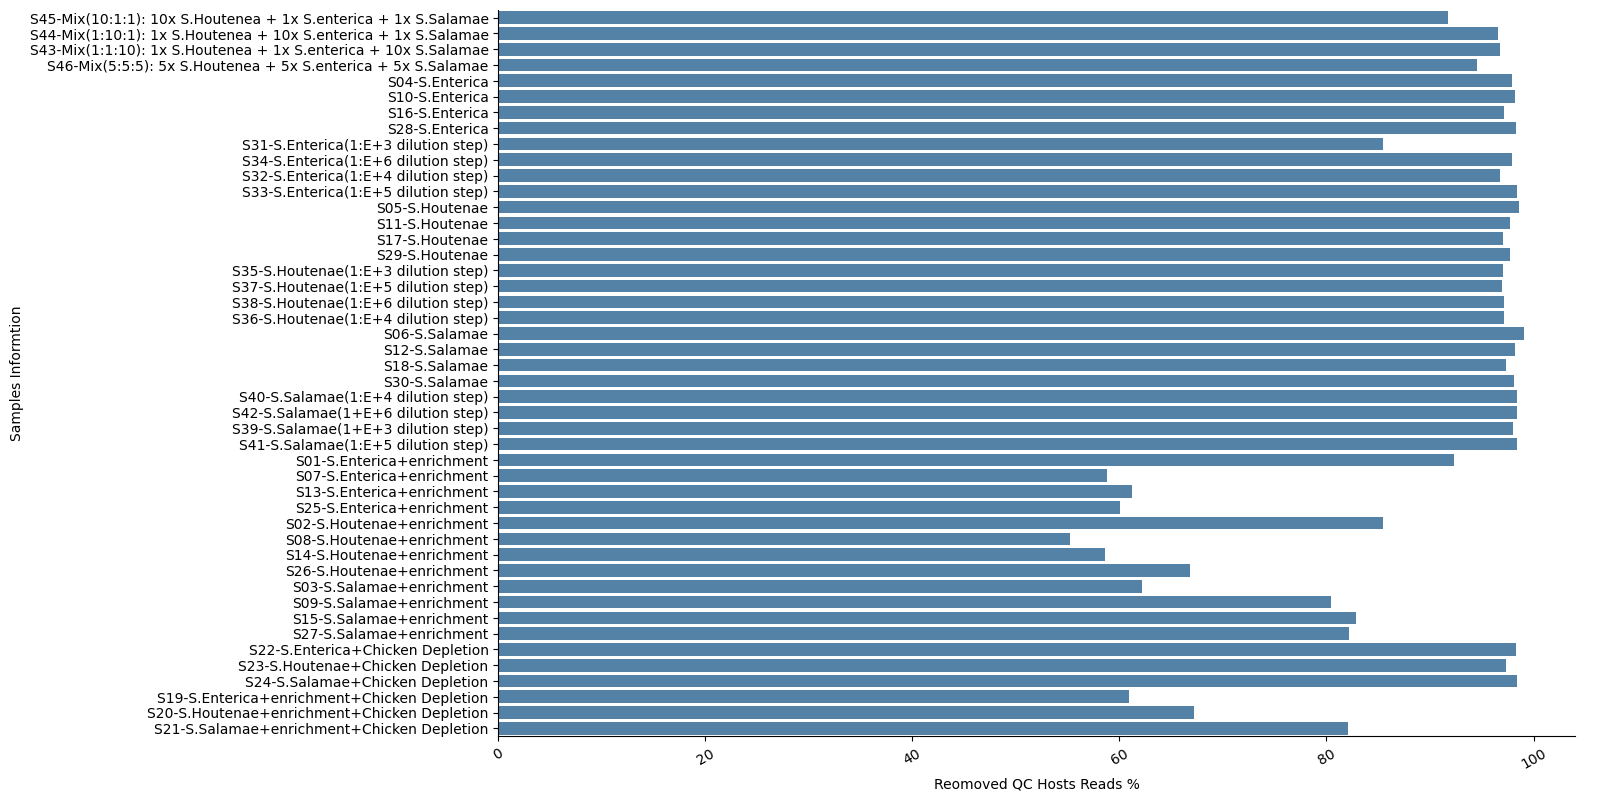

In [5]:
ax = sns.catplot(data=result, kind="bar",x="removed_hosts_percentage", y="Information", height=8, aspect=2, color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("Reomoved QC Hosts Reads %")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("removed_hosts_percentages_per_sample.svg"))
plt.savefig(output_dp / Path("removed_hosts_percentages_per_sample.png"))
plt.show()

## Number of QC all reads vs samples information

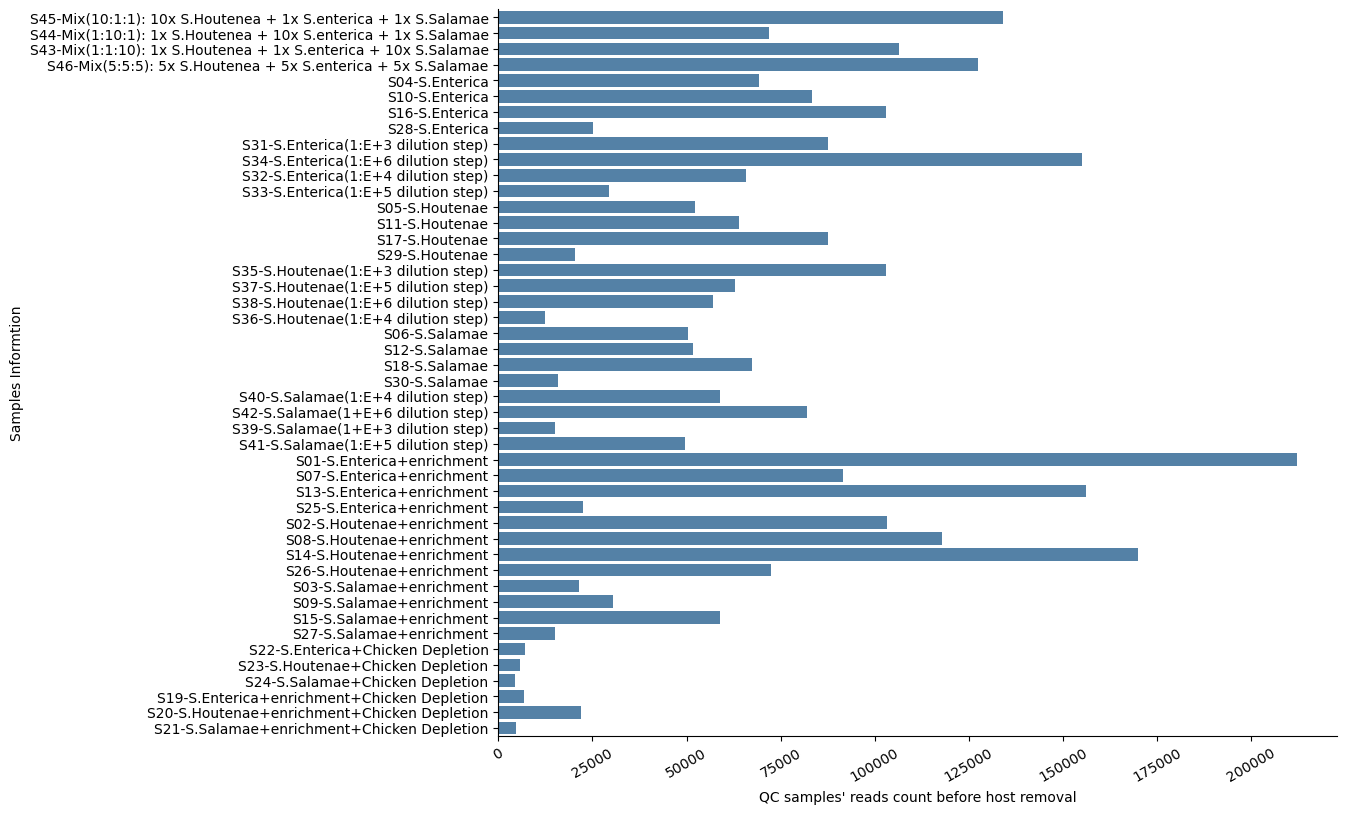

In [6]:
ax = sns.catplot(data=result, kind="bar", x="quality_retained_all_reads", y="Information", height=8, aspect=1.7,color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("QC samples' reads count before host removal")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("quality_controlled_all_reads_count.svg"))
plt.savefig(output_dp / Path("quality_controlled_all_reads_count.png"))
plt.show()

## Number of QC host reads vs samples information

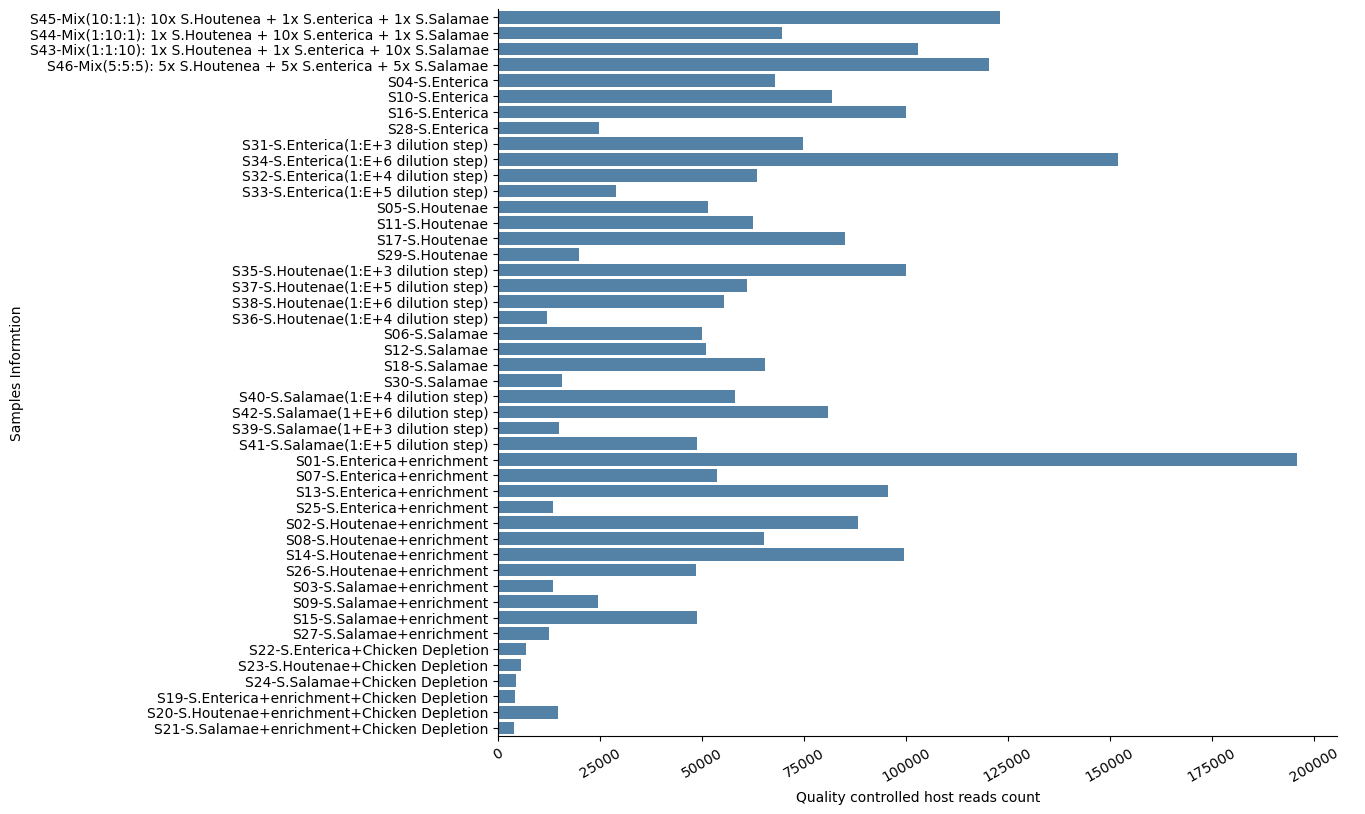

In [7]:
ax = sns.catplot(data=result, kind="bar", x="quality_retained_hosts_reads", y="Information", height=8, aspect=1.7, color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("Quality controlled host reads count")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("quality_controlled_host_reads_count.svg"))
plt.savefig(output_dp / Path("quality_controlled_host_reads_count.png"))
plt.show()

## Number of reads remaning after host filtering

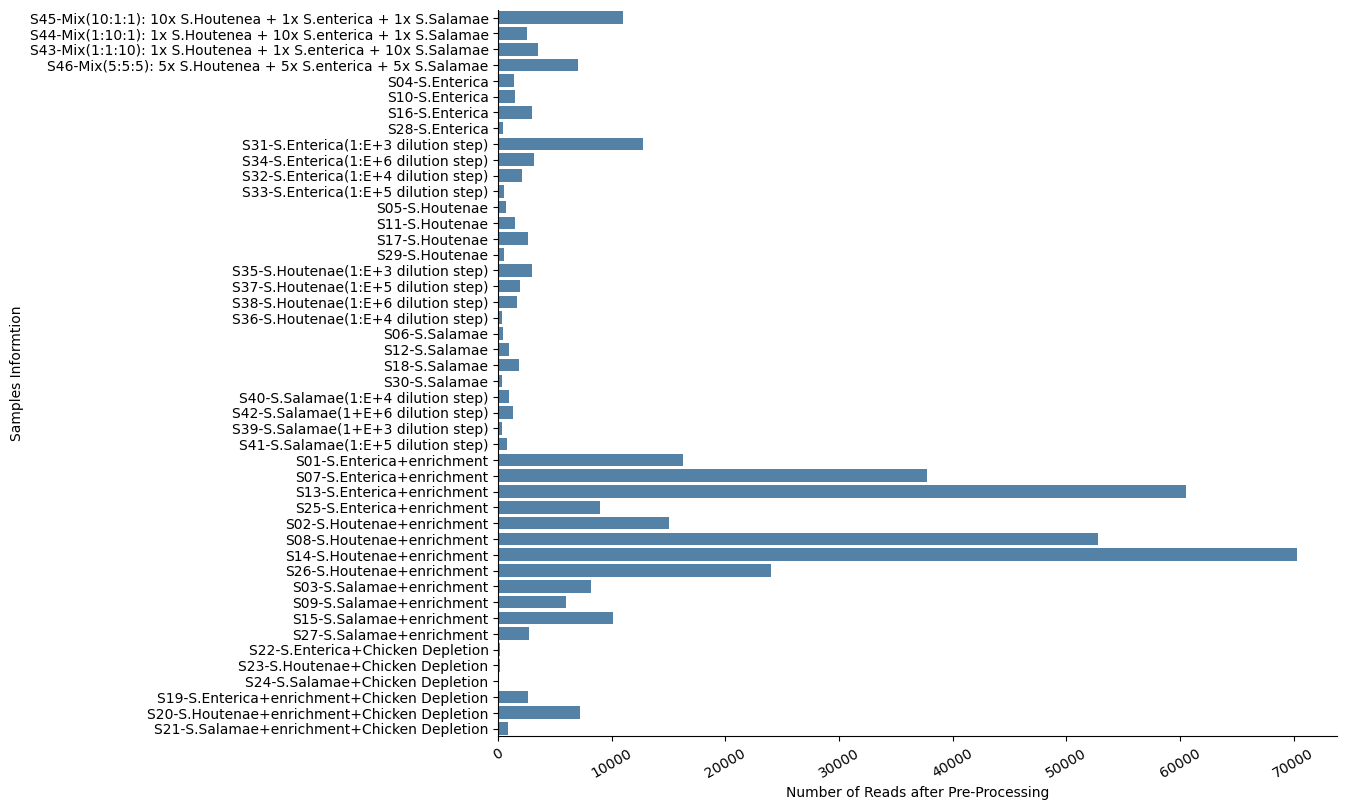

In [8]:
df = pd.DataFrame(result)
df['Difference'] = df["quality_retained_all_reads"].sub(df["quality_retained_hosts_reads"])
ax = sns.catplot(data=df, kind="bar", x="Difference", y="Information", height=8, aspect=1.7, color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("Number of Reads after Pre-Processing")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("remaining_number_of_reads_after_pre_processing.svg"))
plt.savefig(output_dp / Path("remaining_number_of_reads_after_pre_processing.png"))
plt.show()

## Overlapping Bar Plots

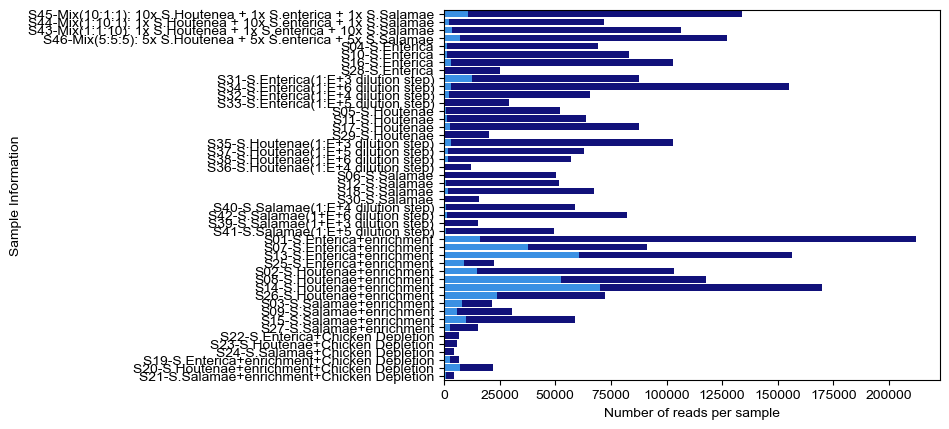

In [9]:
ax=plt.subplots()

#plotting columns
ax=sns.barplot(x=df["quality_retained_all_reads"],y=df["Information"],color = 'darkblue')
ax=sns.barplot(x=df["Difference"],y=df["Information"],color = 'dodgerblue')

#renaming the axes
ax.set(xlabel="Number of reads per sample", ylabel="Sample Information")
sns.set(rc={'figure.figsize':(8,6)})
plt.savefig(output_dp / Path("overlapping_bar_plots_for_before_and_after_host_removal.svg"))
plt.savefig(output_dp / Path("overlapping_bar_plots_for_before_and_after_host_removal.png"))
# visualizing illustration
plt.show()

## Mapping Coverage

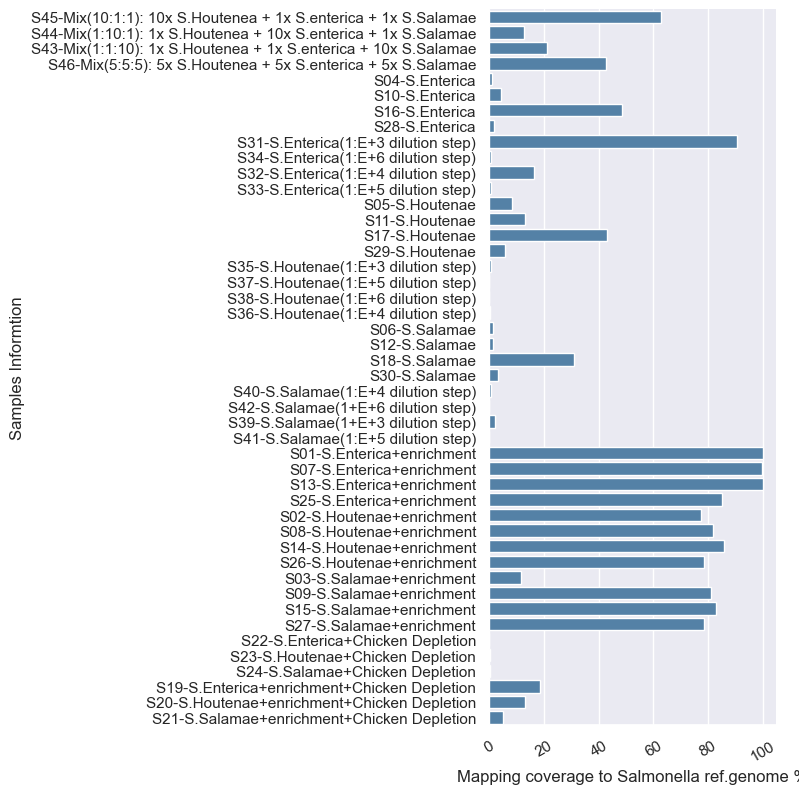

In [10]:
ax = sns.catplot(data=result, kind="bar", x="mapping coverage", y="Information", height=8, color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("Mapping coverage to Salmonella ref.genome %")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("mapping_coverage_to_salmonella_rg.svg"))
plt.savefig(output_dp / Path("mapping_coverage_to_salmonella_rg.png"))
plt.show()

## Number of SNPs found per Sample

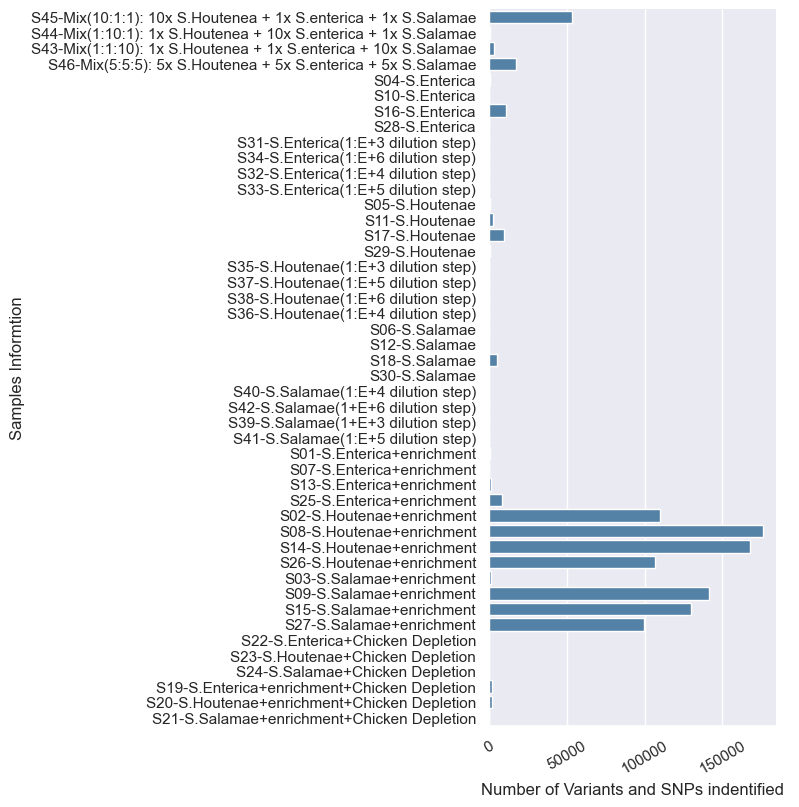

In [11]:
ax = sns.catplot(data=result, kind="bar", x="snps count", y="Information", height=8, color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("Number of Variants and SNPs indentified")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("number_of_snps_and_variants_per_sample.svg"))
plt.savefig(output_dp / Path("number_of_snps_and_variants_per_sample.png"))
plt.show()

## Samples Mapping Depth Mean without Zero Values

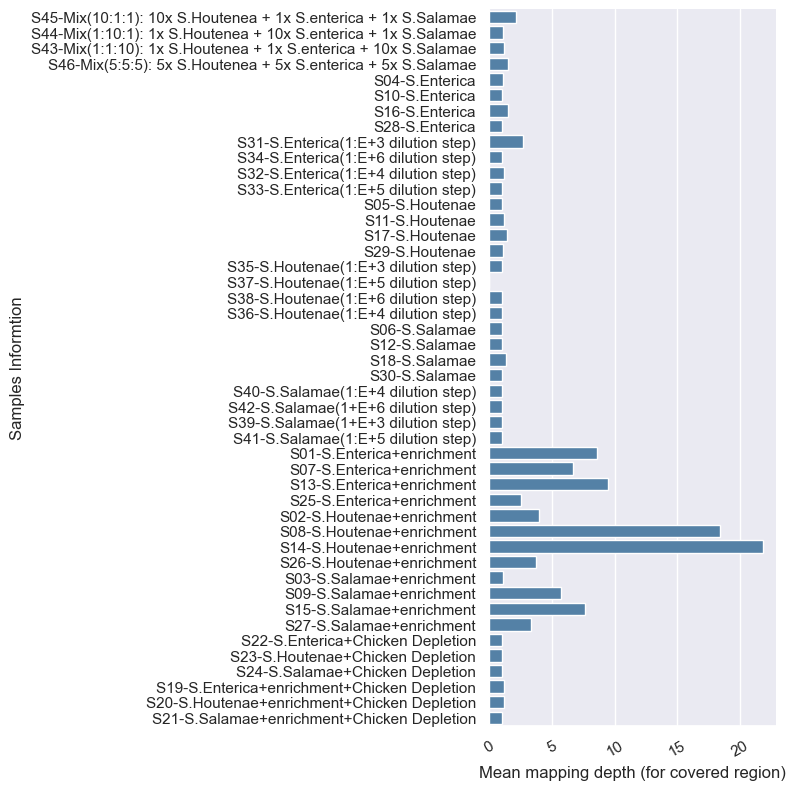

In [12]:
ax = sns.catplot(data=result, kind="bar", x="Mean", y="Information", height=8, color='steelblue')
ax.set_ylabels("Samples Informtion")
ax.set_xlabels("Mean mapping depth (for covered region)")
plt.xticks(rotation=30, horizontalalignment="center")
plt.savefig(output_dp / Path("mapping_depth_mean_per_sample.svg"))
plt.savefig(output_dp / Path("mapping_depth_mean_per_sample.png"))
plt.show()

## Violin Plots

### for VFs vs Enrichment

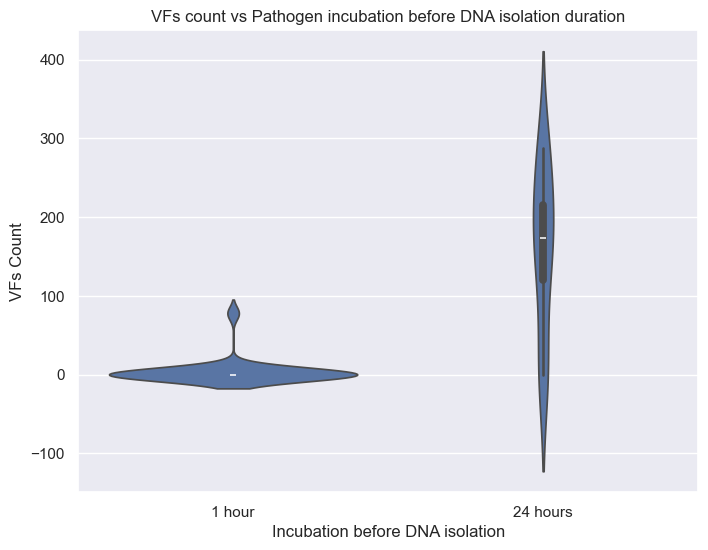

In [13]:
ax = sns.violinplot(data=result, x="Incubation before DNA isolation", y="VFs count")
ax.set_title("VFs count vs Pathogen incubation before DNA isolation duration")
ax.set_ylabel("VFs Count")
plt.savefig(output_dp / Path("violin_plot_vfs_count_vs_incubation.svg"))
plt.savefig(output_dp / Path("violin_plot_vfs_count_vs_incubation.png"))
plt.show()

### for AMRS vs Enrichment


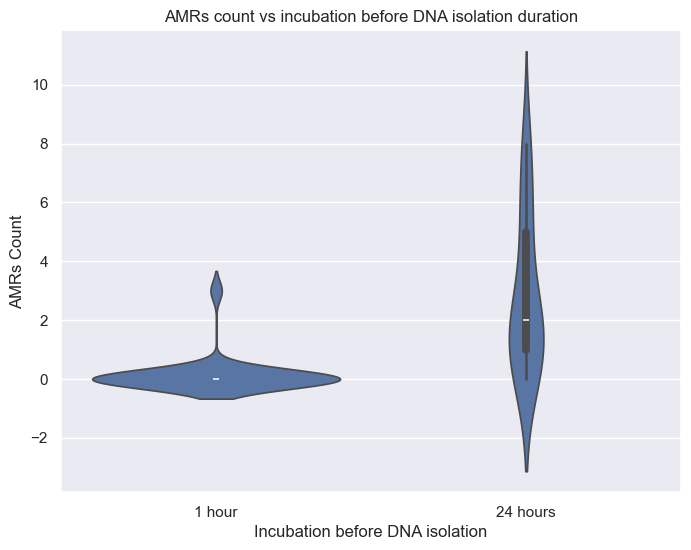

In [14]:
ax = sns.violinplot(data=result, x="Incubation before DNA isolation", y="AMRs count")
ax.set_title("AMRs count vs incubation before DNA isolation duration")
ax.set_ylabel("AMRs Count")
plt.savefig(output_dp / Path("violin_plot_amrs_count_vs_incubation.svg"))
plt.savefig(output_dp / Path("violin_plot_amrs_count_vs_incubation.png"))
plt.show()

### for QC Hosts Removed Reads Percentages vs Deplition

/var/folders/7j/21czvpk170zcyjdbqrp0hmsh0000gn/T/ipykernel_50094/2281216634.py:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.swarmplot(y="removed_hosts_percentage", x="Adaptive sampling during sequencing (Chicken Excluded)", data=result, color="white", edgecolor="gray")


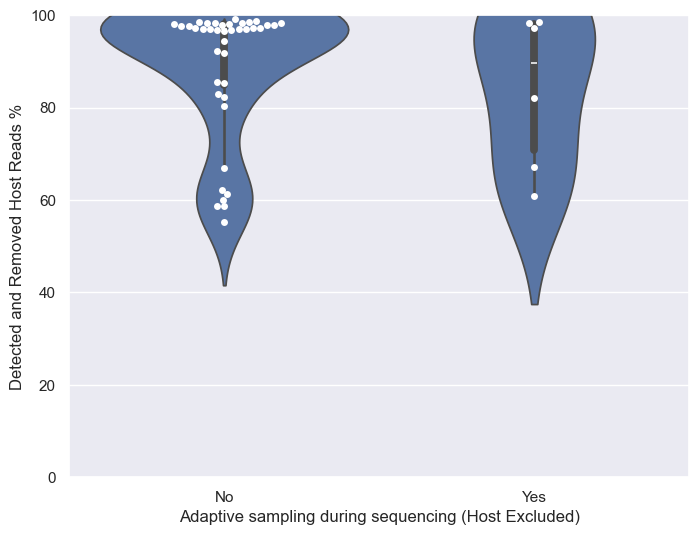

In [15]:
ax = sns.violinplot(data=result, x="Adaptive sampling during sequencing (Chicken Excluded)", y="removed_hosts_percentage")
#ax.set_title("Dectected and Reomoved QC Hosts Reads Percentages vs Chicken Depletion")
sns.swarmplot(y="removed_hosts_percentage", x="Adaptive sampling during sequencing (Chicken Excluded)", data=result, color="white", edgecolor="gray")
ax.set_ylabel("Detected and Removed Host Reads %")
ax.set_xlabel("Adaptive sampling during sequencing (Host Excluded)")
ax.set_ylim([0,100])
plt.savefig(output_dp / Path("violin_plot_removed_hosts_percentage_vs_adaptive_sampling.svg"))
plt.savefig(output_dp / Path("violin_plot_removed_hosts_percentage_vs_adaptive_sampling.png"))
plt.show()

### No. of QC Chicken reads vs Deplition

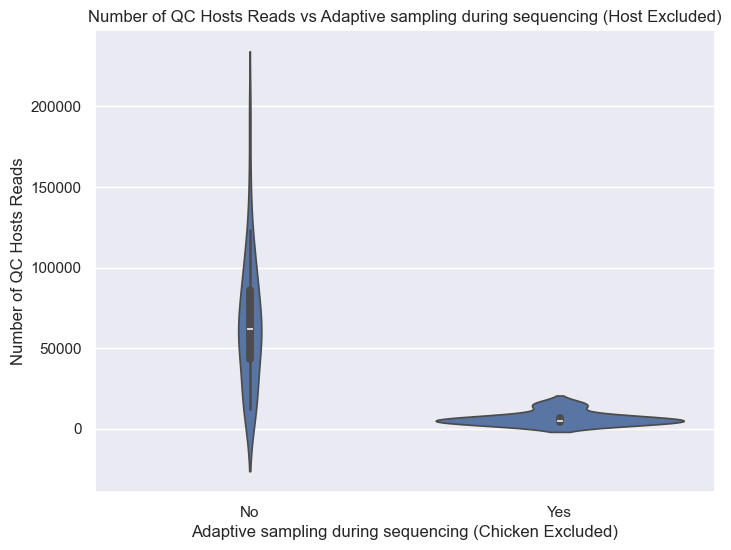

In [16]:
ax = sns.violinplot(data=result, x="Adaptive sampling during sequencing (Chicken Excluded)", y="quality_retained_hosts_reads")
ax.set_title("Number of QC Hosts Reads vs Adaptive sampling during sequencing (Host Excluded)")
ax.set_ylabel("Number of QC Hosts Reads")
plt.savefig(output_dp / Path("violin_plot_removed_hosts_reads_count_vs_adaptive_sampling.svg"))
plt.savefig(output_dp / Path("violin_plot_removed_hosts_reads_count_vs_adaptive_sampling.png"))
plt.show()

### No. of QC Total Reads vs Deplition

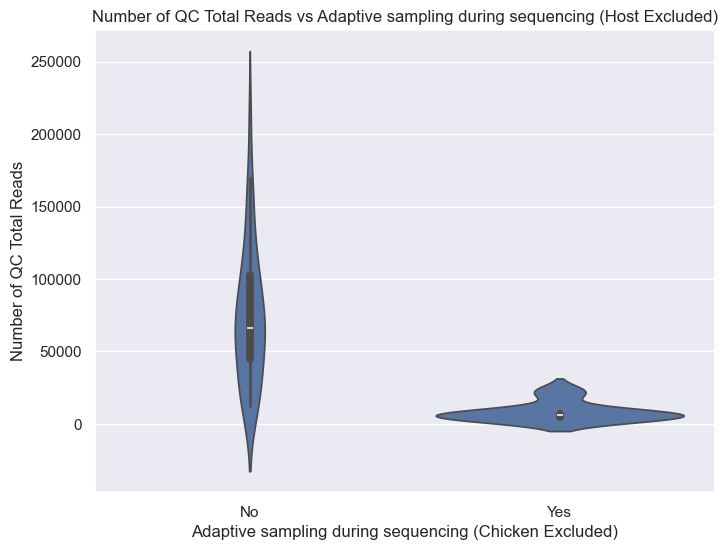

In [17]:
ax = sns.violinplot(data=result, x="Adaptive sampling during sequencing (Chicken Excluded)", y="quality_retained_all_reads")
ax.set_title("Number of QC Total Reads vs Adaptive sampling during sequencing (Host Excluded)")
ax.set_ylabel("Number of QC Total Reads")
plt.savefig(output_dp / Path("violin_plot_QC total_reads_count_vs_adaptive_sampling.svg"))
plt.savefig(output_dp / Path("violin_plot_QC total_reads_count_vs_adaptive_sampling.png"))
plt.show()

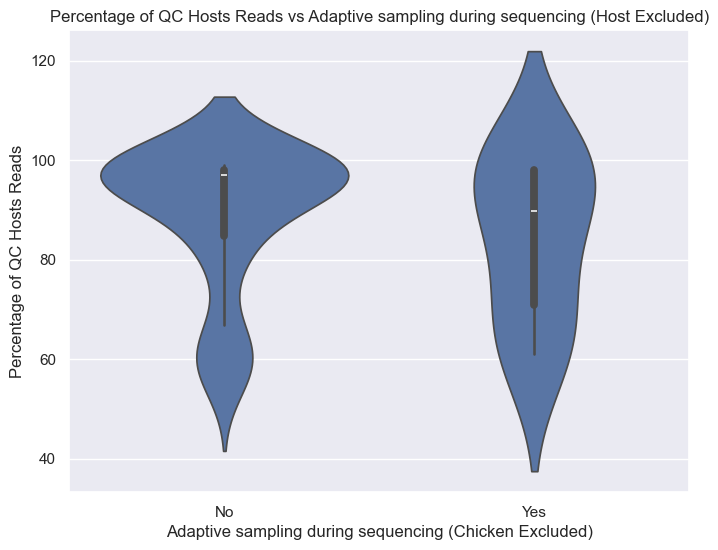

In [18]:
ax = sns.violinplot(data=result, x="Adaptive sampling during sequencing (Chicken Excluded)", y="removed_hosts_percentage")
ax.set_title("Percentage of QC Hosts Reads vs Adaptive sampling during sequencing (Host Excluded)")
ax.set_ylabel("Percentage of QC Hosts Reads")
plt.savefig(output_dp / Path("violin_plot_removed_hosts_reads_percentage_vs_adaptive_sampling.svg"))
plt.savefig(output_dp / Path("violin_plot_removed_hosts_reads_percentage_vs_adaptive_sampling.png"))
plt.show()

## Scattered Plot

### VFs and AMRs Counts vs CT Value

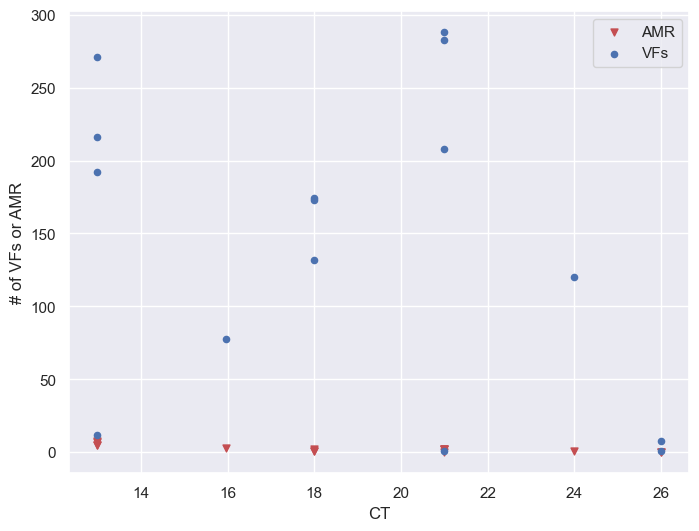

In [19]:
selection = selection.dropna(subset = ["AMRs count","VFs count"])
#selection.set_index(["Enrichment"], drop=True, inplace = True)

ax = selection.plot(kind='scatter', x='CT', y='AMRs count', color='r', marker='v', s=25, label="AMR")    
selection.plot.scatter(
                x = 'CT',
                y = 'VFs count',
                ax=ax, label="VFs")
ax.set_ylabel("# of VFs or AMR")
ax.set_xlabel("CT")
plt.savefig(output_dp / Path("scattered_plot_vfs_amrs_counts_vs_ct.svg"))
plt.savefig(output_dp / Path("scattered_plot_vfs_amrs_counts_vs_ct.png"))
plt.show()

### VFs and AMRs Counts vs CFU value

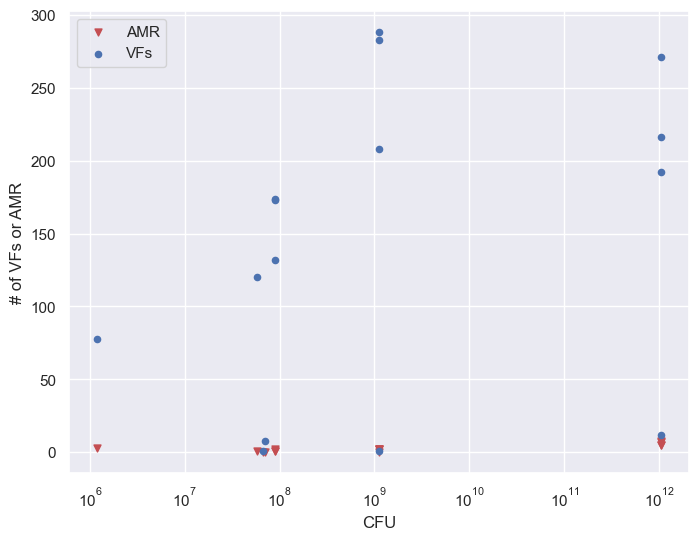

In [20]:
ax = selection.plot(kind='scatter', x='CFU', y='AMRs count', color='r', marker='v', s=25, label="AMR")    
selection.plot.scatter(
                x = 'CFU',
                y = 'VFs count',
                ax=ax, label="VFs")
ax.set_ylabel("# of VFs or AMR")
ax.set_xlabel("CFU")
ax.set_xscale('log')
plt.savefig(output_dp / Path("scattered_plot_vfs_amrs_counts_vs_cfu.svg"))
plt.savefig(output_dp / Path("scattered_plot_vfs_amrs_counts_vs_cfu.png"))
plt.show()

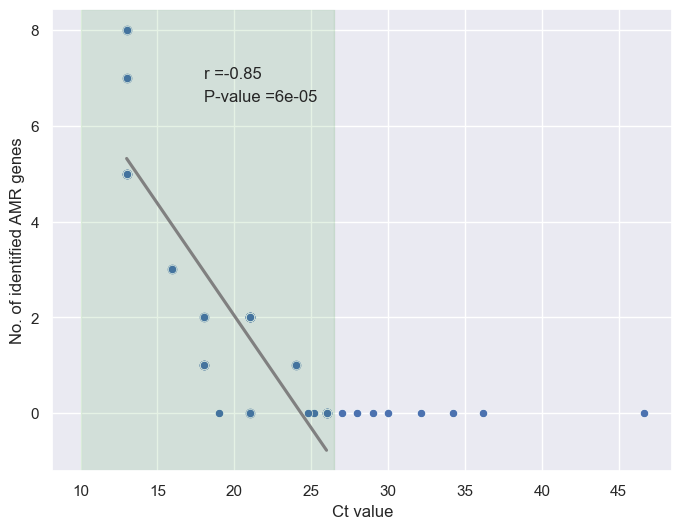

In [21]:
import scipy as sp
selection2 = df
selection2 = selection2.dropna(subset = ["AMRs count","VFs count"])
sns.regplot(x='CT', y='AMRs count', data=selection, ci=None, line_kws={'color':'grey'})
sns.scatterplot(x='CT', y='AMRs count', data=selection2)
plt.xlabel("Ct value")
plt.ylabel("No. of identified AMR genes")
plt.axvspan(10, 26.5, alpha=0.1, color="green")
r, p = sp.stats.pearsonr(selection['CT'], selection['AMRs count'])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.245, .85, "r ={:.2f}".format(r), transform=ax.transAxes)
plt.text(.245, .8, "P-value ={:.0e}".format(p), transform=ax.transAxes)
plt.savefig(output_dp / Path("scattered_plot_AMRs_counts_vs_ct_correlation.svg"))
plt.savefig(output_dp / Path("scattered_plot_AMRs_counts_vs_ct_correlation.png"))
plt.show()

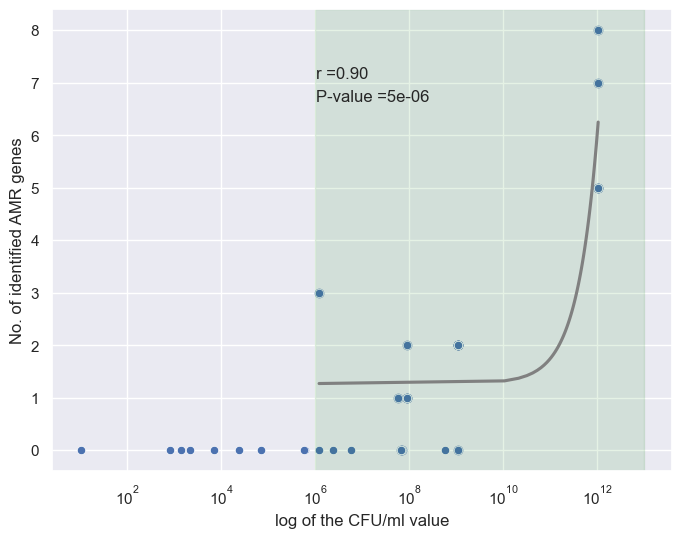

In [22]:
sns.regplot(x='CFU', y='AMRs count', data=selection, ci=None, line_kws={'color':'grey'})
sns.scatterplot(x='CFU', y='AMRs count', data=selection2)
plt.xscale('log')
plt.xlabel("log of the CFU/ml value")
plt.ylabel("No. of identified AMR genes")
plt.axvspan(1000000,1e+13, alpha=0.1, color="green")
r, p = sp.stats.pearsonr(selection['CFU'], selection['AMRs count'])
ax = plt.gca() # Get a matplotlib's axes instance
plt.text(.425, .85, "r ={:.2f}".format(r), transform=ax.transAxes)
plt.text(.425, .8, "P-value ={:.0e}".format(p), transform=ax.transAxes)
plt.savefig(output_dp / Path("scattered_plot_AMRs_counts_vs_cfu_correlation.svg"))
plt.savefig(output_dp / Path("scattered_plot_AMRs_counts_vs_cfu_correlation.png"))
plt.show()

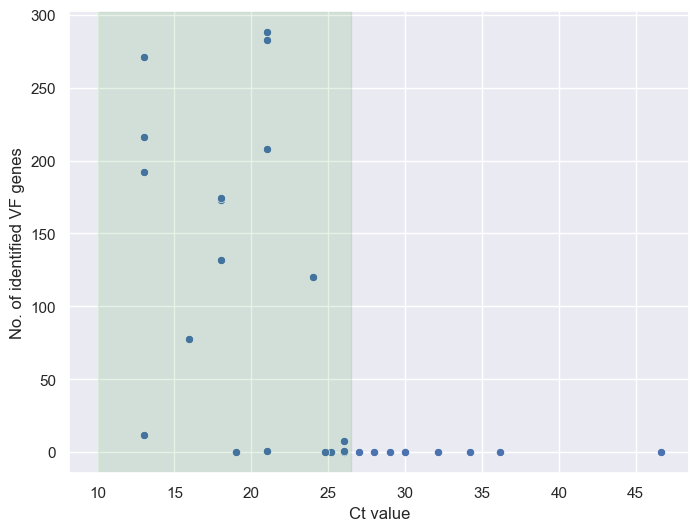

In [23]:
sns.scatterplot(x='CT', y='VFs count', data=selection2)
plt.xlabel("Ct value")
plt.ylabel("No. of identified VF genes")
# Highlighting for a certain period of time
plt.axvspan(10, 26.5, alpha=0.1, color="green")
plt.savefig(output_dp / Path("scattered_plot_vfs_counts_vs_ct.svg"))
plt.savefig(output_dp / Path("scattered_plot_vfs_counts_vs_ct.png"))
plt.show()

In [24]:
from scipy import stats
stats.pearsonr(selection['CT'], selection['VFs count'])

PearsonRResult(statistic=np.float64(-0.3296461759751703), pvalue=np.float64(0.2301951751483892))

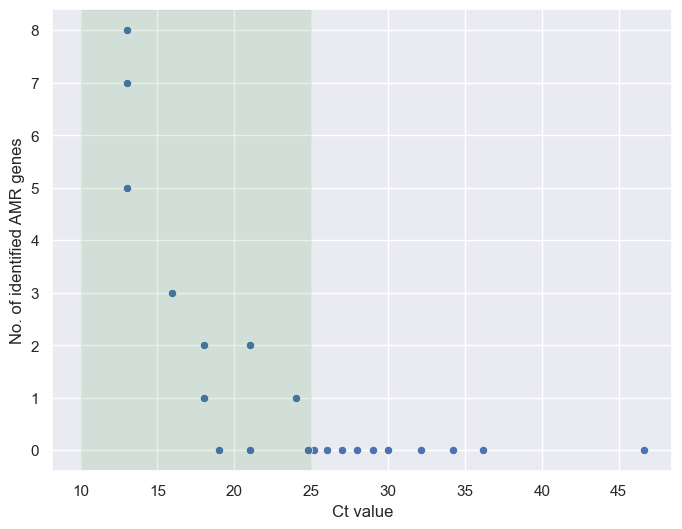

In [25]:
sns.scatterplot(x='CT', y='AMRs count', data=selection2)
plt.xlabel("Ct value")
plt.ylabel("No. of identified AMR genes")
plt.axvspan(10, 25, alpha=0.1, color="green")
plt.savefig(output_dp / Path("scattered_plot_amrs_counts_vs_ct.svg"))
plt.savefig(output_dp / Path("scattered_plot_amrs_counts_vs_ct.png"))
plt.show()

In [26]:
stats.pearsonr(selection['CT'], selection['AMRs count'])

PearsonRResult(statistic=np.float64(-0.8506661783692315), pvalue=np.float64(5.834737820688277e-05))

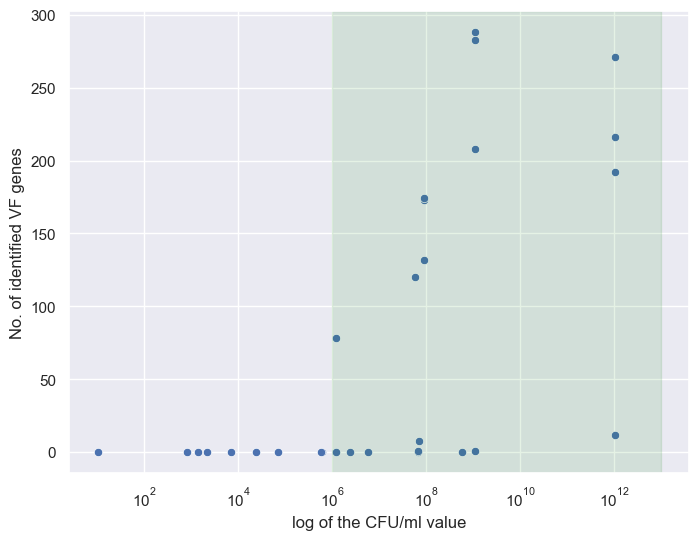

In [27]:
sns.scatterplot(x='CFU', y='VFs count', data=selection2)
plt.xscale('log')
plt.xlabel("log of the CFU/ml value")
plt.ylabel("No. of identified VF genes")
plt.axvspan(1000000,1e+13, alpha=0.1, color="green")
plt.savefig(output_dp / Path("scattered_plot_vfs_counts_vs_cfu.svg"))
plt.savefig(output_dp / Path("scattered_plot_vfs_counts_vs_cfu.png"))
plt.show()


In [28]:
stats.pearsonr(selection['CFU'], selection['VFs count'])

PearsonRResult(statistic=np.float64(0.17413906630800013), pvalue=np.float64(0.5347974854132742))

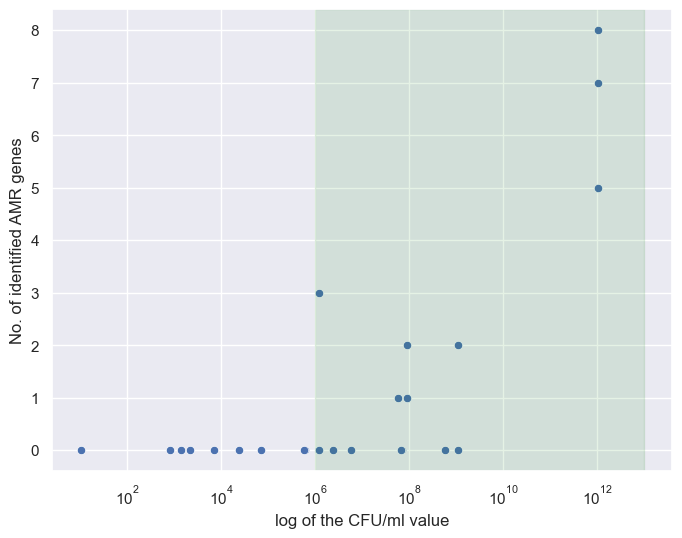

In [29]:
sns.scatterplot(x='CFU', y='AMRs count', data=selection2)  
plt.xscale('log')
plt.xlabel("log of the CFU/ml value")
plt.ylabel("No. of identified AMR genes")
plt.axvspan(1000000,1e+13, alpha=0.1, color="green")
plt.savefig(output_dp / Path("scattered_plot_amrs_counts_vs_cfu.svg"))
plt.savefig(output_dp / Path("scattered_plot_amrs_counts_vs_cfu.png"))
plt.show()

In [30]:
stats.pearsonr(selection['CFU'], selection['AMRs count'])

PearsonRResult(statistic=np.float64(0.9006202067813546), pvalue=np.float64(4.686089651001313e-06))

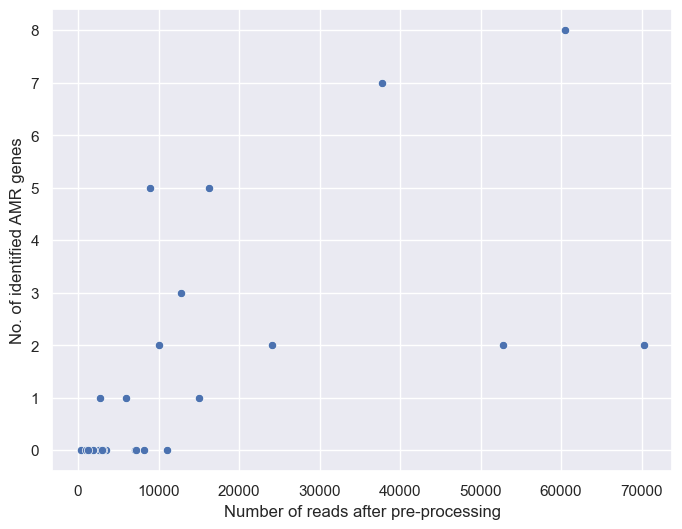

In [31]:
sns.scatterplot(x='Difference', y='AMRs count', data=selection2)  
plt.xlabel("Number of reads after pre-processing")
plt.ylabel("No. of identified AMR genes")
plt.savefig(output_dp / Path("scattered_plot_amrs_counts_vs_no_of_reads.svg"))
plt.savefig(output_dp / Path("scattered_plot_amrs_counts_vs_no_of_reads.png"))
plt.show()

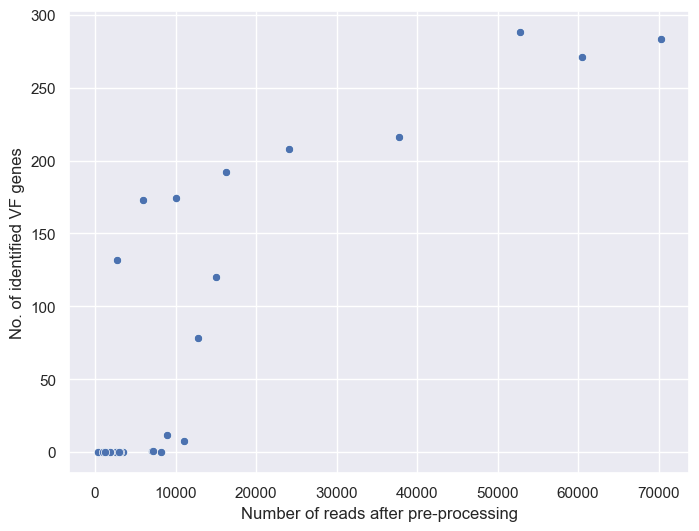

In [32]:
sns.scatterplot(x='Difference', y='VFs count', data=selection2)  
plt.xlabel("Number of reads after pre-processing")
plt.ylabel("No. of identified VF genes")
plt.savefig(output_dp / Path("scattered_plot_vfs_counts_vs_no_of_reads.svg"))
plt.savefig(output_dp / Path("scattered_plot_vfs_counts_vs_no_of_reads.png"))
plt.show()

## HeatMap

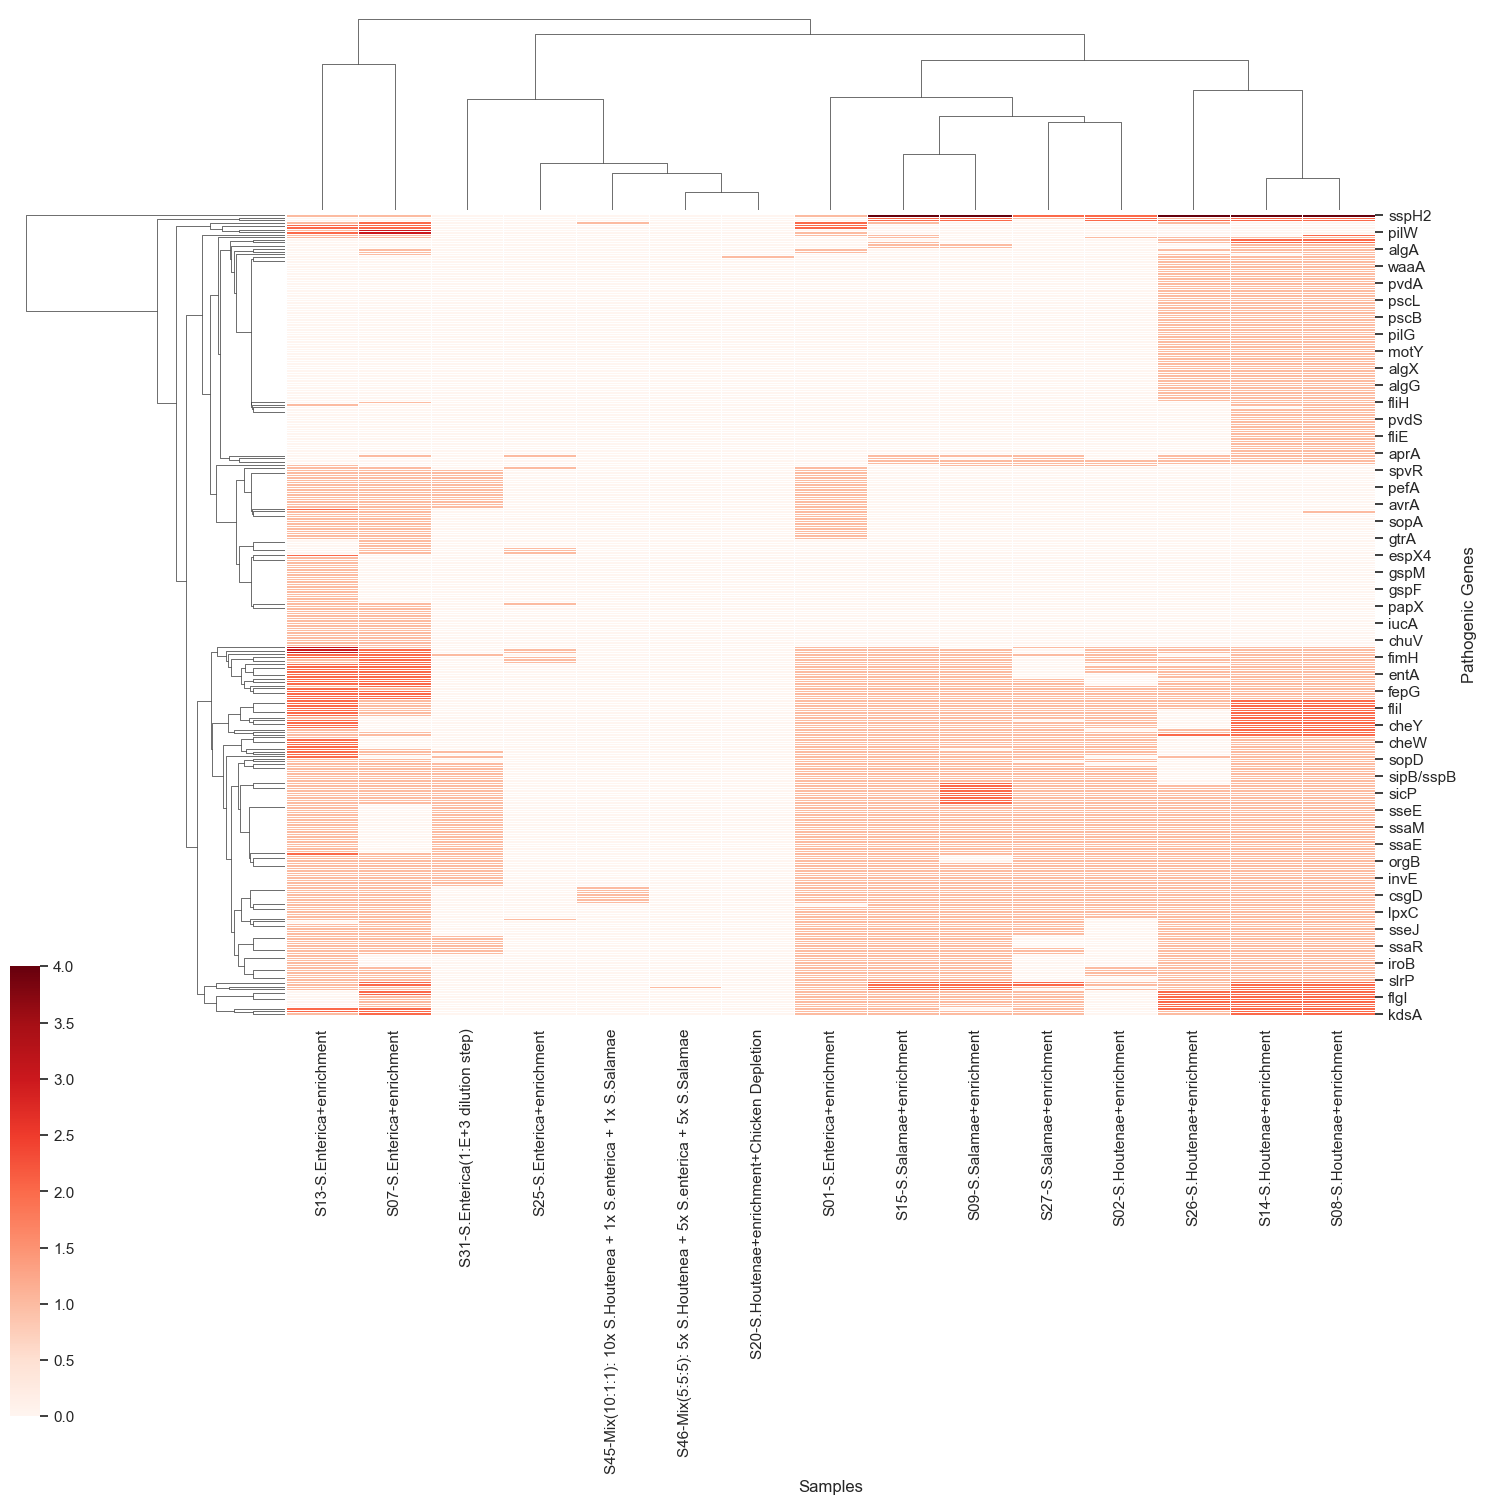

In [33]:
import scipy
heatmap_db
sns.set(font_scale=1)
g = sns.clustermap(heatmap_db, cmap="Reds", xticklabels=True, row_cluster=True, figsize=(15,15), cbar_pos=(0.01, .05, .02, .3), linewidths=0.5)
ax = g.ax_heatmap
ax.set_ylabel("Pathogenic Genes")
ax.set_xlabel("Samples")
# fig = g.get_figure()
plt.savefig(output_dp / Path("clustermap_pathogenic_genes_vs_samples.svg"))
plt.savefig(output_dp / Path("clustermap_pathogenic_genes_vs_samples.png"))

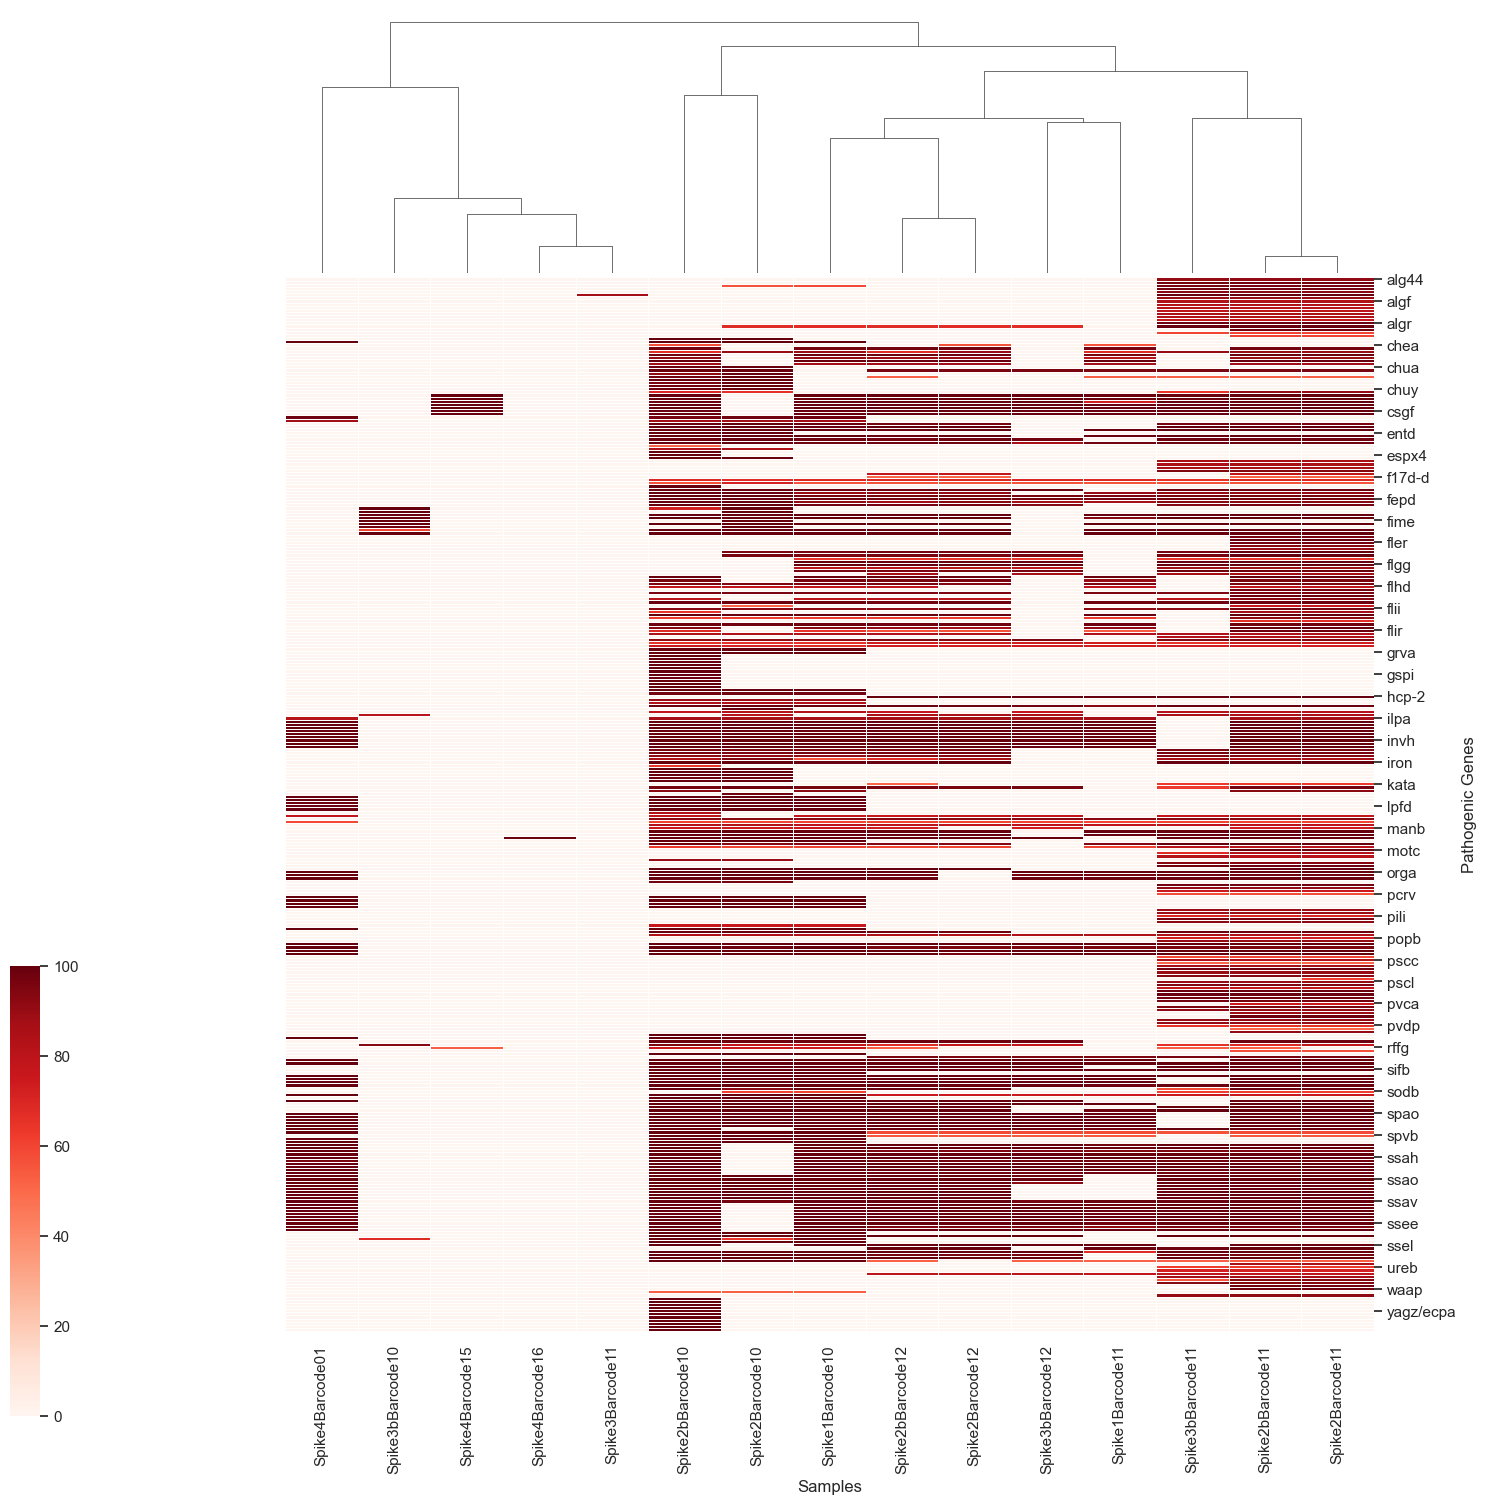

In [34]:
sns.set(font_scale=1)
g = sns.clustermap(coverage_heatmap_db, cmap="Reds", xticklabels=True, row_cluster=False, figsize=(15,15), cbar_pos=(0.01, .05, .02, .3), linewidths=0.5)
ax = g.ax_heatmap
ax.set_ylabel("Pathogenic Genes")
ax.set_xlabel("Samples")
# fig = g.get_figure()
plt.savefig(output_dp / Path("clustermap_pathogenic_genes_coverage_vs_samples.svg"))
plt.savefig(output_dp / Path("clustermap_pathogenic_genes_coverage_vs_samples.png"))

In [35]:
# import widget classes and instantiate Network instance
from clustergrammer2 import Network, CGM2

net = Network(CGM2)


# load matrix file
net.load_file(str(data_dp / "heatmap_tabular_type3_all2.tsv"))

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()

CGM2(network='{"row_nodes": [{"name": "VF Gene: IlpA", "ini": 330, "clust": 157, "rank": 254, "rankvar": 261},…

In [36]:
# load matrix file
net.load_file(str(data_dp / Path("vfs_coverage_heatmap_type2.csv")))

# cluster using default parameters
net.cluster(enrichrgram=True)

# make interactive widget
net.widget()


CGM2(network='{"row_nodes": [{"name": "alg44", "ini": 336, "clust": 244, "rank": 117, "rankvar": 128}, {"name"…

In [37]:
depthpd = pd.read_table(data_dp / Path("depthwithheader.tsv"))
depthpd = depthpd.replace(0, np.nan)
depthmean = depthpd.mean(axis=0)
depthmean = depthmean.replace(np.nan, 0)
print(depthmean)

Spike4Barcode16      1.466004
Spike4Barcode15      2.103518
Spike4Barcode14      1.084713
Spike4Barcode13      1.161053
Spike4Barcode12      1.000000
Spike4Barcode11      1.000000
Spike4Barcode10      1.000000
Spike4Barcode09      1.007895
Spike4Barcode08      1.000000
Spike4Barcode07      0.000000
Spike4Barcode06      1.000000
Spike4Barcode05      1.000000
Spike4Barcode04      1.003290
Spike4Barcode03      1.007893
Spike4Barcode02      1.149754
Spike2bBarcode10     9.471170
Spike2bBarcode11    21.838950
Spike2bBarcode12     7.605100
Spike2bBarcode13     1.505989
Spike2bBarcode14     1.373602
Spike2bBarcode15     1.338714
Spike3Barcode10      1.148320
Spike3Barcode11      1.145992
Spike3Barcode12      1.021743
Spike3Barcode13      1.000000
Spike3Barcode14      1.000000
Spike3Barcode15      1.000000
Spike3bBarcode10     2.503440
Spike3bBarcode11     3.697774
Spike3bBarcode12     3.331824
Spike3bBarcode13     1.009889
Spike3bBarcode14     1.068714
Spike3bBarcode15     1.000000
Spike4Barc

In [38]:
depthmean.to_csv(output_dp / Path("meandepth.csv"), index=False)

# PathoGFAIR Benchmark

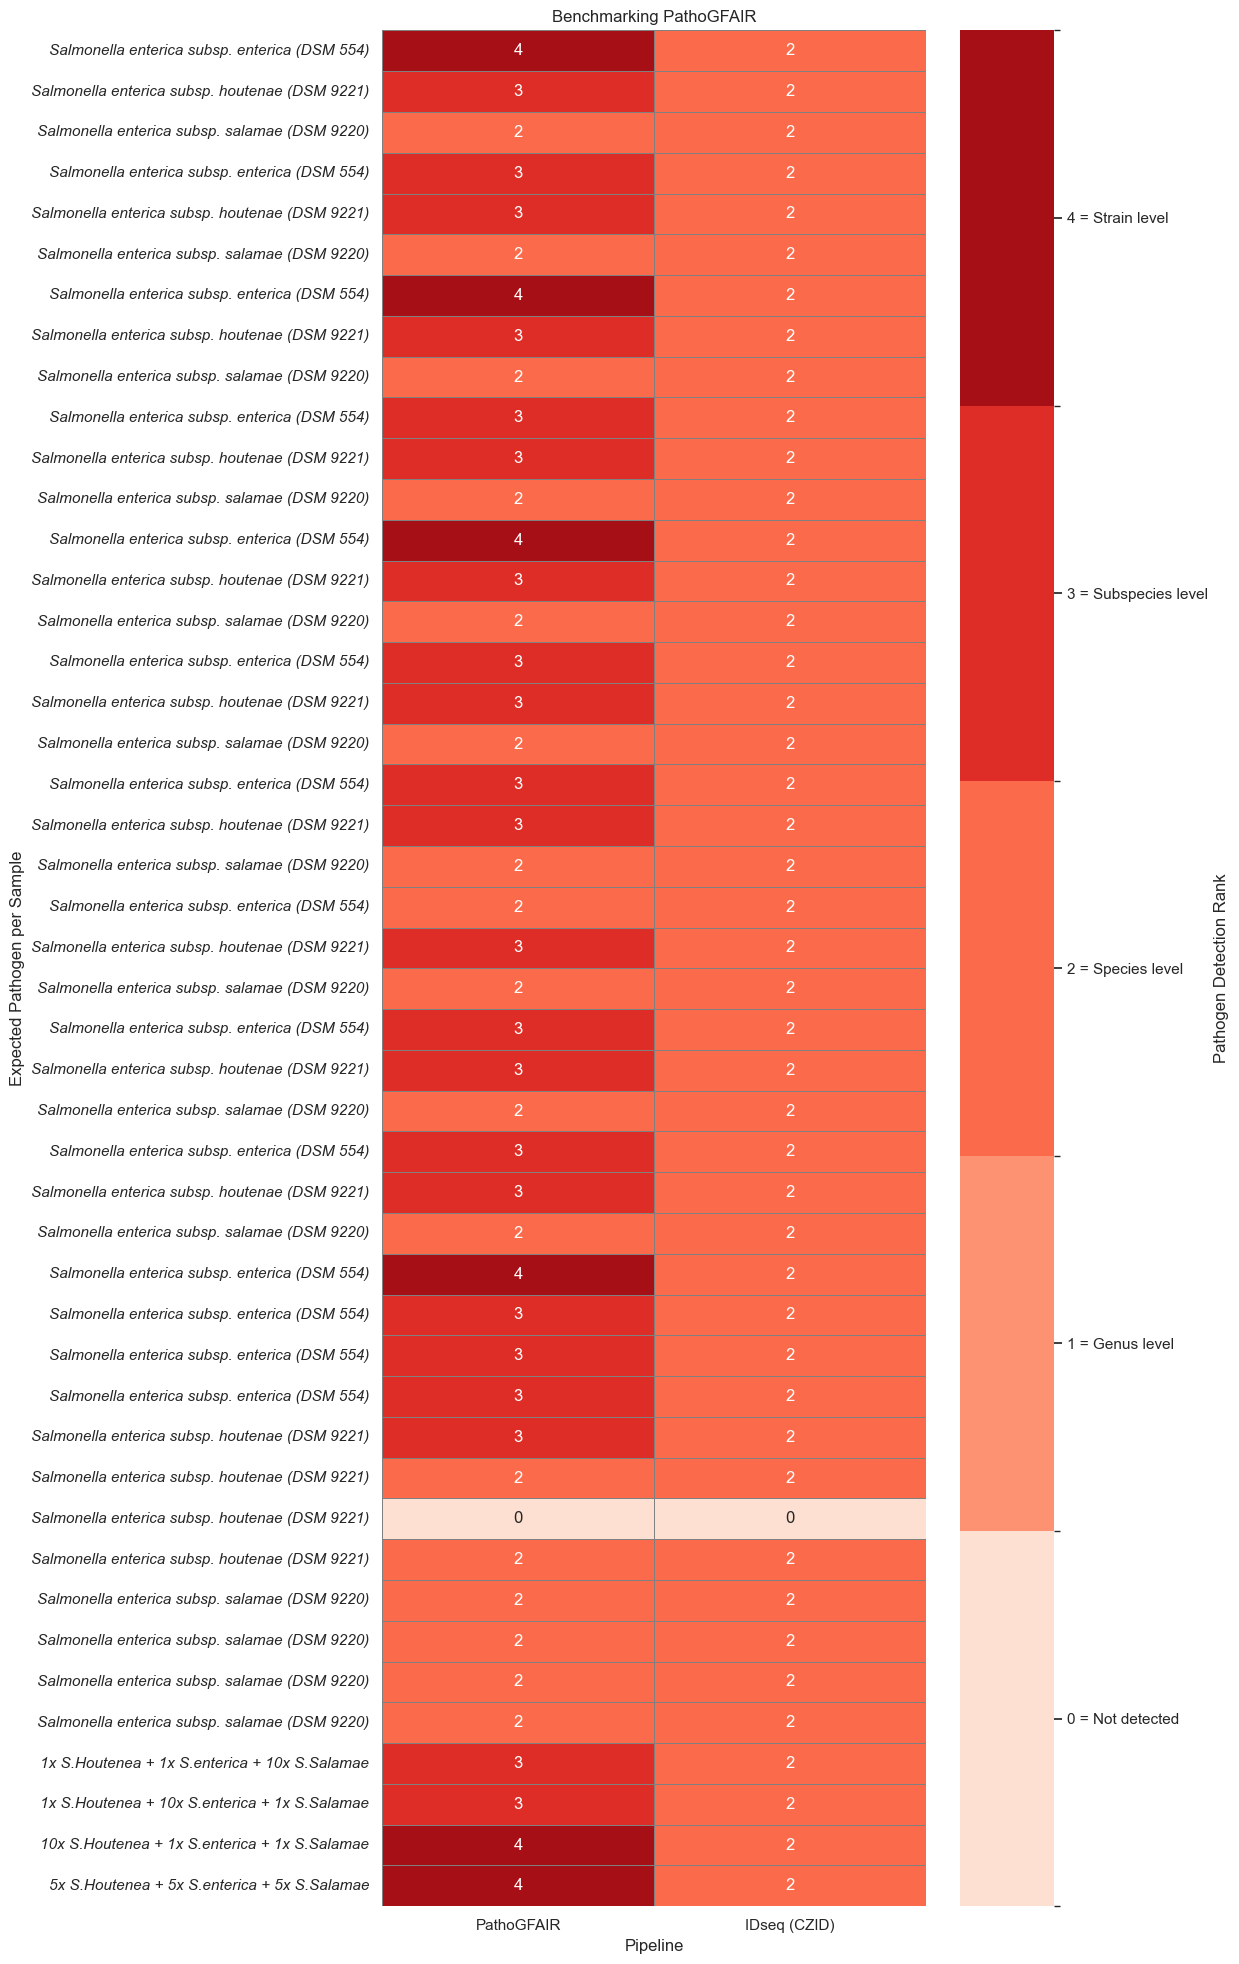

In [39]:
from matplotlib.colors import ListedColormap, BoundaryNorm


# Define a discrete colormap for each rank level
cmap = ListedColormap(['#fee0d2', '#fc9272', '#fb6a4a', '#de2d26', '#a50f15'])  # shades of red
norm = BoundaryNorm(boundaries=[0, 1, 2, 3, 4, 5], ncolors=5)

# Create the heatmap with discrete color levels
plt.figure(figsize=(12, len(heatmap_benchmark_db) * 0.3 + 6))  # Adjust height based on number of rows
heatmap = sns.heatmap(
    heatmap_benchmark_db, annot=True, cmap=cmap, norm=norm, linewidths=0.5, linecolor='grey',
    cbar_kws={'label': 'Pathogen Detection Rank'},
    vmin=0, vmax=4
)

heatmap.set_yticklabels(heatmap.get_yticklabels(), fontstyle="italic")

# Set title and labels
plt.title('Benchmarking PathoGFAIR')
plt.xlabel('Pipeline')
plt.ylabel('Expected Pathogen per Sample')

# Customize the color bar to show only the discrete rank levels
colorbar = heatmap.collections[0].colorbar
colorbar.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5])
colorbar.set_ticklabels([
    '0 = Not detected',
    '1 = Genus level',
    '2 = Species level',
    '3 = Subspecies level',
    '4 = Strain level'
])

plt.tight_layout()
#plt.show()
plt.savefig(output_dp / Path("benchmark_heatmap.svg"))
plt.savefig(output_dp / Path("benchmark_heatmap.png"))

In [40]:
# Calculate percentages of each detection rank (2, 3, 4) for PathoGFAIR and IDSeq columns
pathogfair_counts = heatmap_benchmark_db['PathoGFAIR'].value_counts(normalize=True) * 100
idseq_counts = heatmap_benchmark_db['IDseq (CZID)'].value_counts(normalize=True) * 100

# Filter only the values we're interested in (2, 3, 4) and round for readability
pathogfair_results = pathogfair_counts.loc[[0, 2, 3, 4]].round(2)
idseq_results = idseq_counts.loc[[0, 2]].round(2)

pathogfair_results, idseq_results

(PathoGFAIR
 0     2.17
 2    36.96
 3    47.83
 4    13.04
 Name: proportion, dtype: float64,
 IDseq (CZID)
 0     2.17
 2    97.83
 Name: proportion, dtype: float64)